In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
df_clean = pd.read_csv("../Clean_Input_Data/credit_card_churn_clean.csv")
df_clean

,Unnamed: 0,customer_id,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,credit_limit,total_revolving_bal,active_customer
0,0,768805383,45,M,3,1,married,2,blue,39,5,12691.0,777,True
1,1,818770008,49,F,5,2,single,0,blue,44,6,8256.0,864,True
2,2,713982108,51,M,3,2,married,3,blue,36,4,3418.0,0,True
3,4,709106358,40,M,3,0,married,2,blue,21,5,4716.0,0,True
4,5,713061558,44,M,2,2,married,1,blue,36,3,4010.0,1247,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,10120,710841183,54,M,1,1,single,2,blue,34,5,13940.0,2109,True
7077,10121,713899383,56,F,1,2,single,0,blue,50,4,3688.0,606,True
7078,10122,772366833,50,M,2,2,single,1,blue,40,3,4003.0,1851,True
7079,10124,716506083,44,F,1,1,married,0,blue,36,5,5409.0,0,False


# Split data

In [54]:

from sklearn.model_selection import train_test_split

def split_dataFrame(df_to_split, y_column):
    df_full_train, df_test = train_test_split(df_to_split, test_size=0.2, random_state=11)
    df_train,  df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

    df_full_train = df_full_train.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_full_train = df_full_train[y_column]
    y_train = df_train[y_column]
    y_val = df_val[y_column]
    y_test = df_test[y_column]


    del df_full_train[y_column]
    del df_train[y_column]
    del df_val[y_column]
    del df_test[y_column]

    # with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    #     display(df_test)   

    print("df_to_split length: ", len(df_to_split))
    print()
    print("df_full_train length: ", len(df_full_train))
    print("df_train length: ", len(df_train))
    print("df_val length: ", len(df_val))
    print("df_test length: ", len(df_test))
    print()
    print("y_full_train length: ", len(y_full_train))
    print("y_train length: ", len(y_train))
    print("y_val length: ", len(y_val))
    print("y_test length: ", len(y_test))
    
    return df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test

In [55]:
y_column = "active_customer"
train_columns = ["customer_age", "gender", "dependent_count", "education_level", "marital_status", "income_category", "card_category", "months_on_book", "total_relationship_count", "credit_limit", "total_revolving_bal"]

df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test = split_dataFrame(df_clean[train_columns+[y_column]], y_column)
df_train

df_to_split length:  7081

df_full_train length:  5664
df_train length:  4248
df_val length:  1416
df_test length:  1417

y_full_train length:  5664
y_train length:  4248
y_val length:  1416
y_test length:  1417


,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,credit_limit,total_revolving_bal
0,41,F,4,2,single,0,blue,26,5,1783.0,1282
1,51,M,2,0,married,2,blue,40,2,3559.0,0
2,47,M,5,1,married,3,blue,37,2,9410.0,0
3,53,M,2,2,married,2,blue,38,6,7928.0,1228
4,40,M,4,1,married,2,blue,36,6,5797.0,1779
...,...,...,...,...,...,...,...,...,...,...,...
4243,46,M,3,3,married,2,blue,39,3,13344.0,1907
4244,44,M,2,0,divorced,2,blue,34,6,3650.0,1270
4245,51,M,0,2,married,3,blue,40,4,7158.0,0
4246,48,F,3,3,divorced,1,blue,41,4,9336.0,1672


## Model training with XGboost

In [56]:
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

def train(dataFrame, y, max_depth, eta):
    # Hot Encoding
    dicts = dataFrame.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    features = dv.get_feature_names_out()
    dtrain = xgb.DMatrix(X, label=y, feature_names=features)

    # train
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed':1,
        'verbosity':0
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    return dv, model

dv, model = train(df_train, y_train, 6, 0.3)

In [57]:
def predict(dataFrame, dv, model):
    dicts = dataFrame.to_dict(orient="records")
    X = dv.transform(dicts)
    features = dv.get_feature_names_out()
    dval = xgb.DMatrix(X, feature_names=features)
    y_pred = model.predict(dval)
    return y_pred, X


y_pred_val, X_val = predict(df_val, dv, model)
df_pred_val_result = df_val.copy()
df_pred_val_result['y_pred'] = y_pred_val
df_pred_val_result['y_pred_bool'] = df_pred_val_result['y_pred']>0.5
df_pred_val_result['y_val'] = y_val
df_pred_val_result

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,credit_limit,total_revolving_bal,y_pred,y_pred_bool,y_val
0,62,F,1,2,single,0,blue,56,1,3109.0,0,0.266958,False,False
1,49,F,3,1,married,0,blue,45,3,1438.3,726,0.859267,True,True
2,45,M,4,2,married,4,blue,36,5,34516.0,880,0.964725,True,True
3,52,M,1,2,married,2,blue,43,3,7187.0,2014,0.929658,True,True
4,42,F,4,2,single,0,blue,36,6,2803.0,0,0.696427,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,57,F,1,0,single,0,blue,46,2,9129.0,0,0.472798,False,False
1412,38,M,2,2,married,3,blue,29,5,7535.0,2517,0.873151,True,True
1413,50,M,2,2,married,4,blue,43,3,20114.0,0,0.659105,True,True
1414,59,F,1,2,single,0,blue,39,5,4404.0,2272,0.944803,True,True


In [58]:
# MAE, MSE, RMSE

from sklearn import metrics
import numpy as np
import pandas as pd

df_pred = pd.DataFrame(y_pred_val, columns=["predicted_months_on_book"])

mae = metrics.mean_absolute_error(y_val, y_pred_val)
mse = metrics.mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))

print("MAE for numerical linear:", mae)
print("MSE for numerical linear:", mse)
print("RMSE for numerical linear:", rmse)


MAE for numerical linear: 0.21851909
MSE for numerical linear: 0.11331143
RMSE for numerical linear: 0.33661765


Model max deviation +/-0.00: 0.000 percent
Model max deviation +/-0.05: 31.073 percent
Model max deviation +/-0.10: 54.308 percent
Model max deviation +/-0.15: 61.299 percent
Model max deviation +/-0.20: 65.325 percent
Model max deviation +/-0.25: 69.350 percent
Model max deviation +/-0.30: 73.376 percent
Model max deviation +/-0.35: 76.695 percent
Model max deviation +/-0.40: 80.085 percent
Model max deviation +/-0.45: 82.627 percent
Model max deviation +/-0.50: 84.534 percent
Model max deviation +/-0.55: 85.946 percent
Model max deviation +/-0.60: 88.206 percent
Model max deviation +/-0.65: 89.901 percent
Model max deviation +/-0.70: 91.172 percent
Model max deviation +/-0.75: 92.726 percent
Model max deviation +/-0.80: 94.633 percent
Model max deviation +/-0.85: 95.904 percent
Model max deviation +/-0.90: 97.034 percent
Model max deviation +/-0.95: 98.517 percent
Model max deviation +/-1.00: 99.929 percent


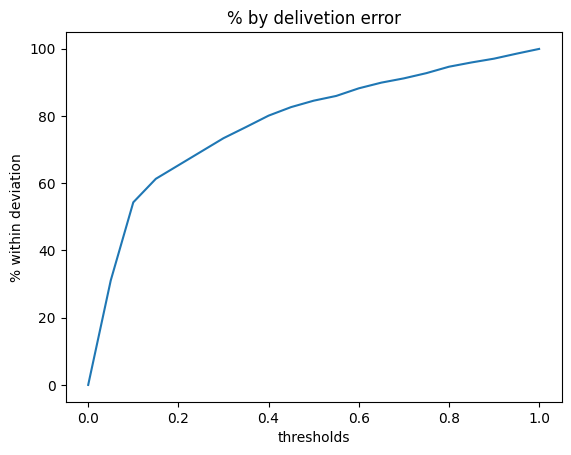

In [59]:
import matplotlib.pyplot as plt
from sklearn import metrics

thresholds = np.linspace(0, 1, 21)
y_count = len(df_pred.predicted_months_on_book)

scores = []
for t in thresholds:
    dev_within_t = (abs(y_pred_val-y_val) < t).sum()
    score = (dev_within_t*100)/y_count
    scores.append(score)
    print('Model max deviation +/-%.2f: %.3f percent' % (t, score))

plt.xlabel('thresholds')
plt.ylabel('% within deviation')
plt.title('% by delivetion error')
plt.plot(thresholds, scores)

##  Train model and sent to MLFlow

In [60]:
import os
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import mlflow
import pickle
from hyperopt import hp, space_eval
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

In [61]:
import mlflow


## after configuring aws instance connection run this : 

mlflow.set_tracking_uri("http://15.207.72.49:5000")    ## instance created for mlops
mlflow.set_experiment('notebook-exp')

<Experiment: artifact_location='s3://mlops-s3-bucket-1/1', creation_time=1675198424200, experiment_id='1', last_update_time=1675198424200, lifecycle_stage='active', name='notebook-exp', tags={}>

In [62]:
mlflow.xgboost.autolog(disable=True)

xgb_params_search_space = {
    'max_depth': scope.int(hp.choice('max_depth', [5, 10, 12, 13, 14, 20,30,40,50,100])),
    'eta': scope.int(hp.choice('eta', [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 5, 10])),
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'verbosity':0,
    "seed":42
}

In [63]:
def objective(params):
    with mlflow.start_run():
        active_mlflow_run_id = mlflow.active_run().info.run_id
        if (active_mlflow_run_id==None): raise ValueError("missing MLFlow active run.")
        print(f'Training model. Active MLFlow run_id: {active_mlflow_run_id}')
        mlflow.set_tag("model", "xgboost")

        dv = DictVectorizer(sparse=False)
        X_full_train = dv.fit_transform(df_full_train.to_dict(orient='records'))
        X_val = dv.transform(df_val.to_dict(orient='records'))
        features = dv.get_feature_names_out()
        dtrain = xgb.DMatrix(X_full_train, label=y_full_train.values, feature_names=features)
        dvalid = xgb.DMatrix(X_val, label=y_val.values, feature_names=features)

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=100,
            evals=[(dvalid, 'validation')],
            early_stopping_rounds=50
        )

        X_val = dv.transform(df_val.to_dict(orient='records'))
        dtrain = xgb.DMatrix(X_val, label=y_val.values, feature_names=features)
        y_pred_val = booster.predict(dvalid)

        rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))
        mlflow.log_metric("rmse", rmse) 
        
        os.makedirs("models", exist_ok=True)
        
        with open("models/preprocessor.b","wb") as f_out:
            pickle.dump(dv,f_out)
        
        mlflow.log_artifact("models/preprocessor.b",artifact_path="preprocessor")
    
        mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")
        print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")
        

    return {'loss':rmse, 'status':STATUS_OK}

In [64]:
best_result = fmin(
    fn=objective,
    space=xgb_params_search_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=Trials()
)

Training model. Active MLFlow run_id: 368b09e8e91f47918867ceb9b497e8c4                                                                                     
[0]	validation-rmse:0.50460                                                                                                                                
[1]	validation-rmse:0.49492                                                                                                                                
[2]	validation-rmse:0.49996                                                                                                                                
[3]	validation-rmse:0.48907                                                                                                                                
[4]	validation-rmse:0.49317                                                                                                                                
[5]	validation-rmse:0.48885                                     

[1]	validation-rmse:0.50000                                                                                                                                
[2]	validation-rmse:0.50000                                                                                                                                
[3]	validation-rmse:0.50000                                                                                                                                
[4]	validation-rmse:0.50000                                                                                                                                
[5]	validation-rmse:0.50000                                                                                                                                
[6]	validation-rmse:0.50000                                                                                                                                
[7]	validation-rmse:0.50000                                     

## Load model from MLFlow and predict once

In [67]:
import mlflow


RUN_ID = 'de0a9f14ea3f475984d6a265b3a93cbf'

logged_model = f's3://mlops-s3-bucket-1/1/{RUN_ID}/artifacts/models_mlflow'
# logged_model = f'runs:/{RUN_ID}/model'
model = mlflow.pyfunc.load_model(logged_model)

In [68]:
model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: de0a9f14ea3f475984d6a265b3a93cbf

In [69]:
## convering into xgboost model
xgboost_model = mlflow.xgboost.load_model(logged_model)

xgboost_model

In [72]:
with open('../Experiment_Tracking/models/preprocessor.b', 'rb') as f_in:
    dv_mlflow = pickle.load(f_in)


In [73]:
pred_dict = {"customer_age":100,"gender":"F","dependent_count":2,"education_level":2,"marital_status":"married","income_category":2,"card_category":"blue","months_on_book":6,"total_relationship_count":3,"credit_limit":float(4000),"total_revolving_bal":2500}


X = dv_mlflow.transform(pred_dict)
features = dv_mlflow.get_feature_names_out()
dpred = xgb.DMatrix(X, feature_names=features)
xgboost_model.predict(dpred)

array([0.5], dtype=float32)